In [4]:
from qmachine.pulse_generator.pulse_generator import Pulse_builder
import pandas as pd
import numpy as np

In [5]:
def hold_action(channel,time,looped=False):
    return {'action':'hold' , 'channel':channel , 'action_variables':{'time':time},'looped':looped}

def step_action(channel,value,time,looped=False,looped_variable='step_value',loop_index=0):
    return {'action':'step' , 'channel':channel , 'action_variables':{'time':time,'step_value':value},'looped':looped,'looper':looped_variable,'loop_index':loop_index}

def ramp_action(channel,rate,time,looped=False):
    return {'action':'ramp' , 'channel':channel , 'action_variables':{'time':time,'rate':rate},'looped':looped}

def meas_action(channel,type='full',pulse='readout_pulse_0_05',looped=False,buffer_size=16,slices=100,analog_output='out1'):
    return {'action':'meas' , 'channel':channel , 'action_variables':{'type':type , 'pulse':pulse,'buffer_size':buffer_size,'slices':slices,'analog_output':analog_output},'looped':looped}

def ramp_to_zero_action(channel,time=None):
    return {'action':'ramp_to_zero','channel':channel,'action_variables':{'time':time},'looped':False}

In [6]:
dividers = {'ch1': 8.18*1e-3, 'ch2': 8.27*1e-3} #ch1 is BNC36/j5, ch2 is BNC29/j7, the 1e-3 is to account for values listed being in mV not V
df = pd.read_csv('funnel.csv')
df['m22']=[False]*5
df

FileNotFoundError: [Errno 2] No such file or directory: 'funnel.csv'

In [ ]:
def make_zero_avg(df,channel):
    other_cols=[i for i in df.columns.values if 'ch' not in i and 'm1' not in i and 'm2' not in i]
    channel_df=df[[channel]+other_cols].copy(deep=True)
    total_offset=0
    for index,row in channel_df.iterrows():
        row[channel]=row[channel].split(',')
        if len(row[channel])==1:
            total_offset+=float(row[channel][0])*float(row['time'])
        if len(row[channel])==2:
            
            total_offset+=(float(row[channel][1])+float(row[channel][0]))/2*float(row['time']) #ramp
        if len(row[channel])==3:
            total_offset+=np.linspace(float(row[channel][0]),float(row[channel][1]),int(row[channel][2]))*float(row['time'])
        # print(total_offset)

    return calc_offset_comp(total_offset)

def calc_offset_comp(offset,correction_len=30):
    return offset/correction_len


zero_avg_ch1=make_zero_avg(df,'ch1')
zero_avg_ch2=make_zero_avg(df,'ch2')

In [ ]:
time1=int(1e4/4)
time2=int(1.5e4/4)
time3=int(200/4)
time4=int(3e4//4)

time1_r=time1*4
time2_r=time2*4
time3_r=time3*4

ch1_rate=(-3.58-(-6.62))/1e4*dividers['ch1'] #V/ns
ch2_rate=(6.32-(-5.42))/1e4*dividers['ch2'] #V/ns
print(f'ch1_rate,total_change: {ch1_rate,ch1_rate*1e4}, ch2_rate,total_change: {ch2_rate,ch2_rate*1e4}')


n_loops=300 #default

actions={'steps':{
                '1':
                    {'ch1':step_action('ch1',-6.62*dividers['ch1'],time1),
                     'ch2':step_action('ch2',-5.42*dividers['ch2'],time1)
                     },
                '2':
                    {'ch1':ramp_action('ch1',ch1_rate,time1),
                     'ch2':ramp_action('ch2',ch2_rate,time1)
                    },
                '3':
                    {
                     'ch1':step_action('ch1',(-0.38-(-3.58))*dividers['ch1'],time2),
                     'ch2':step_action('ch2',(0.325-6.32)*dividers['ch2'],time2),
                     'm1':meas_action('m1','full','readout_pulse_0_2',buffer_size=[n_loops])
                    },
                '4':
                    {'ch1':step_action('ch1',np.linspace(0,(30.416-(-0.38))*dividers['ch1'],n_loops),time3,looped=True,loop_index='0'),
                     'ch2':step_action('ch2',np.linspace(0,(-25.978-(0.325))*dividers['ch2'],n_loops),time3,looped=True,loop_index='0')                        
                    },
                '5':
                    {'ch1':step_action('ch1',-np.linspace(0,(30.416-(-0.38))*dividers['ch1'],n_loops),time2,looped=True,loop_index='0'),
                     'ch2':step_action('ch2',-np.linspace(0,(-25.978-(0.325))*dividers['ch2'],n_loops),time2,looped=True,loop_index='0'),
                     'm1':meas_action('m1','full','readout_pulse_0_2',buffer_size=[n_loops])                        
                    },
                '6':
                    {'ch1':step_action('ch1',zero_avg_ch1*dividers['ch1']-(-0.38*dividers['ch1']),time4,looped=True,loop_index='0'),
                     'ch2':step_action('ch2',zero_avg_ch2*dividers['ch2']-(0.325*dividers['ch2']),time4,looped=True,loop_index='0')
                    },
                '7':
                    {
                    'ch1':ramp_to_zero_action('ch1',1),
                    'ch2':ramp_to_zero_action('ch2',1) #these actions nescessary possibly due to too low resolution on the ramp rate, -> ramp is inprecise?
                    },
                '8':
                    {
                    'ch1':hold_action('ch1',time=time1),
                    # 'ch2':hold_action('ch2',time=time1) #these actions nescessary possibly due to too low resolution on the ramp rate, -> ramp is inprecise?
                    }
                },
        'looped':[n_loops],
        'channels':['ch1','ch2','m1']}




one_loop_time=(3*time1+2*time2+time3+time4)
print(f'loop time in us:{one_loop_time*4/1e3}')


import pprint
pprint.pprint(actions)


ch1_rate,total_change: (2.48672e-06, 0.0248672), ch2_rate,total_change: (9.708979999999998e-06, 0.09708979999999999)
loop time in us:90.2
{'channels': ['ch1', 'ch2', 'm1'],
 'looped': [300],
 'steps': {'1': {'ch1': {'action': 'step',
                         'action_variables': {'step_value': -0.0541516,
                                              'time': 2500},
                         'channel': 'ch1',
                         'loop_index': 0,
                         'looped': False,
                         'looper': 'step_value'},
                 'ch2': {'action': 'step',
                         'action_variables': {'step_value': -0.0448234,
                                              'time': 2500},
                         'channel': 'ch2',
                         'loop_index': 0,
                         'looped': False,
                         'looper': 'step_value'}},
           '2': {'ch1': {'action': 'ramp',
                         'action_variables': {'rate': 2.486

In [ ]:
from pprint import pprint
# pprint(df)
pb = Pulse_builder(dividers)
pb.make_dict(df,averages=100)
pprint(pb.actions_dict)

{'channels': ['ch1', 'ch2', 'm11', 'm22', 'time'],
 'looped': [100, 250],
 'steps': {'1': {'ch1': {'action': 'step',
                         'action_variables': {'step_value': -0.0541516,
                                              'time': 2500},
                         'channel': 'ch1',
                         'loop_index': '0',
                         'looped': False,
                         'looper': 'step_value'},
                 'ch2': {'action': 'step',
                         'action_variables': {'step_value': -0.0448234,
                                              'time': 2500},
                         'channel': 'ch2',
                         'loop_index': '0',
                         'looped': False,
                         'looper': 'step_value'}},
           '2': {'ch1': {'action': 'ramp',
                         'action_variables': {'rate': 2.4867200000000004e-06,
                                              'time': 2500},
                         'channel

In [ ]:
for key,value1 in pb.actions_dict['steps'].items():
    for key,value in value1.items():
        if value['looped']:
            value['loop_index']=str(value['loop_index'])

In [ ]:
# a note on how to retrieve data when it is saved using .save_all() with no buffering on the stream
# all_data = {name : data.fetch_all() for name,data in job.result_handles._all_results.items()}
# all_data = {name : [k[0] for k in data] for name,data in all_data.items()}

In [ ]:
from qmachine.pulse_generator.pulse_generator import Pulse_builder,Pulser
import pandas as pd
import numpy as np
dividers = {'ch1': 8.18*1e-3, 'ch2': 8.27*1e-3}

In [ ]:
time_df = pd.read_csv('dephasing_220602_tektronix_differential.csv')
# time_df['time'].iloc[0]=f'{10-0.16},{10-2.16},3'
# time_df['time'].iloc[1]=f'{0.16},{2.16},3'
# time_df['ch1'].iloc[1] = '31.1086'
# time_df['ch2'].iloc[1] = '-25.17'
time_df

C:\Users\T7-2\AppData\Local\Temp\ipykernel_25084\2129756483.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_df['time'].iloc[0]=f'{10-0.16},{10-2.16},3'
C:\Users\T7-2\AppData\Local\Temp\ipykernel_25084\2129756483.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_df['time'].iloc[1]=f'{0.16},{2.16},3'
C:\Users\T7-2\AppData\Local\Temp\ipykernel_25084\2129756483.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_df['ch

,Unnamed: 0,name,time,type,ch1,ch2,m11,m21,m12,m22
0,1,reference,"9.84,7.84,3",ramp,-0.874,0.747,True,False,False,False
1,2,pulse,"0.16,2.16,3",ramp,31.1086,-25.17,False,False,False,False
2,3,measure,10.0,ramp,-0.874,0.747,True,False,False,False
3,4,unload,10.0,ramp,30.412,-25.983,False,False,False,False
4,5,load,10.0,ramp,"-6.62, -3.58","-5.42, 6.32",False,False,False,False


In [ ]:
from pprint import pprint
pb = Pulse_builder(dividers)
new_dict,_ = pb.make_dict(time_df,measpulse='readout_pulse_0_2')
pprint(new_dict)

{'channels': ['ch1', 'ch2', 'm11', 'm22', 'time'],
 'looped': [3],
 'steps': {'1': {'ch1': {'action': 'step',
                         'action_variables': {'step_value': -0.00714932,
                                              'time': [2460, 2210, 1960]},
                         'channel': 'ch1',
                         'loop_index': '0',
                         'looped': True,
                         'looper': 'time'},
                 'ch2': {'action': 'step',
                         'action_variables': {'step_value': 0.00617769,
                                              'time': [2460, 2210, 1960]},
                         'channel': 'ch2',
                         'loop_index': '0',
                         'looped': True,
                         'looper': 'time'},
                 'm11': {'action': 'meas',
                         'action_variables': {'analog_output': 'out1',
                                              'buffer_size': 16,
                             

In [ ]:
from config import config
pulser =Pulser(config,measpulse='readout_pulse_0_2')

readout length: 10000ns


In [ ]:
pulser.channel_dict={'ch1':'Q1_L' , 'ch2':'Q1_R', 'm11':'Q1_readout' , 'm22':'Q1_readout'}
seq,new_dict2 = pulser.build_seq(new_dict)

[2460, 2210, 1960]
[2460, 2210, 1960]
[40, 290, 540]
[40, 290, 540]


2022-06-27 16:51:52,636 - qm - INFO - Performing health check
2022-06-27 16:51:52,648 - qm - INFO - Health check passed
quantum machine opened with channels ['Q1_R', 'Q1_L', 'Q1_readout', 'Q2_readout']
default value for CW is: 0.25
2022-06-27 16:51:52,704 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2022-06-27 16:51:52,747 - qm - INFO - Flags: 
2022-06-27 16:51:52,748 - qm - INFO - Simulating program


(<qm.QmJob.QmJob at 0x1df9ee11090>,
 (None, None))

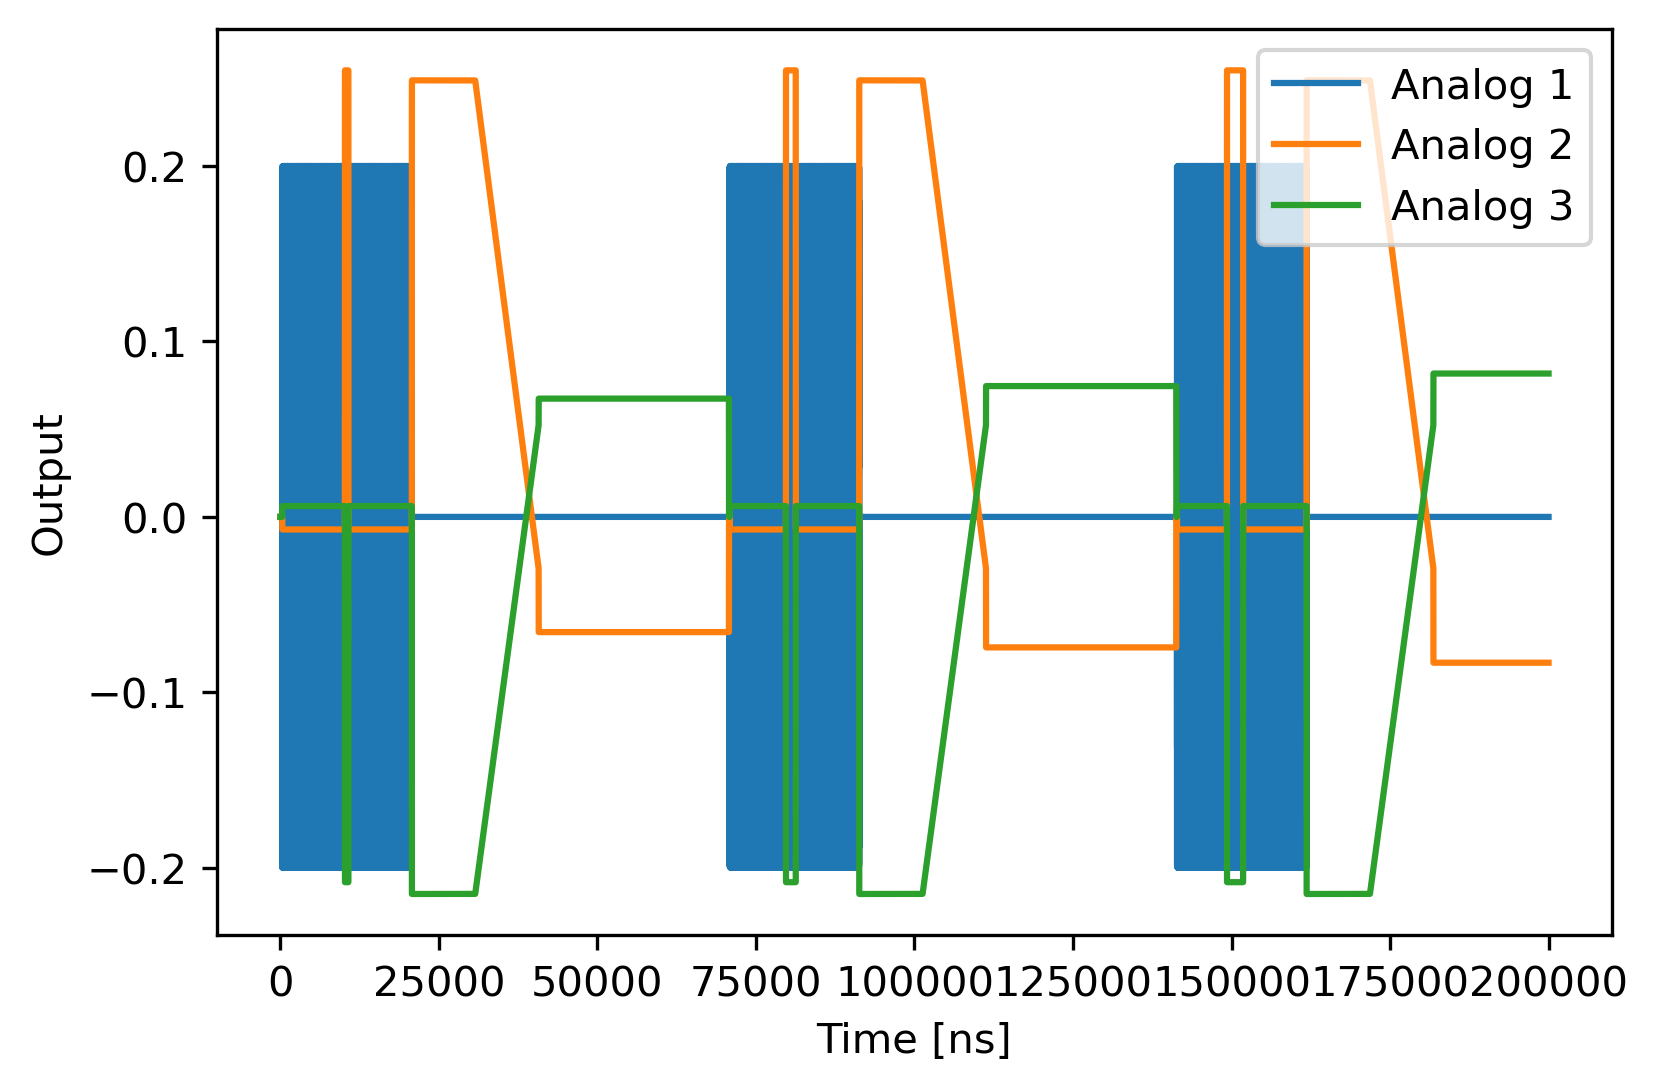

In [ ]:
import matplotlib
matplotlib.rcParams['figure.dpi']=300
pulser.simulate_pulse(seq,int(5e4),close_others=True)

In [ ]:
from qm.qua import program,for_,stream_processing,declare,declare_stream,wait,measure,play,save,fixed,demod,ramp,amp,if_,elif_,else_,align, ramp_to_zero
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm import SimulationConfig
from qm import generate_qua_script

import pandas
import numpy as np
import matplotlib.pyplot as plt
import pprint

In [ ]:
qmm = QuantumMachinesManager(host='192.168.15.128',port=80)
qm = qmm.open_qm(config,close_other_machines=True)

2022-06-27 16:19:10,993 - qm - INFO - Performing health check
2022-06-27 16:19:11,008 - qm - INFO - Health check passed


In [ ]:
with program() as test:
    a=declare(int,value=np.linspace(2499,2474,26,dtype=int).tolist())  

# changing DF struct

In [1]:
import pandas as pd
import numpy as np
from qmachine.pulse_generator.pulse_generator import Pulse_builder
from config import config
from pprint import pprint

time_df = pd.read_csv('dephasing_220602_tektronix_differential.csv')
time_df['time'].iat[0]=f'{10.0}'
time_df['time'].iat[1]=f'{0.2}'
time_df['ch1'].iat[1] = '0,31.1086,100'
time_df['ch2'].iat[1] = '0,-25.17,100'
meas_column = [1,0,100,0,0]
loop_column = [np.nan,0,0,np.nan,np.nan]
time_df['meas'] = meas_column
time_df['loops'] = loop_column
time_df = time_df.drop(['Unnamed: 0','m11','m21','m12','m22','type'],axis='columns')
time_df

,name,time,ch1,ch2,meas,loops
0,reference,10.0,-0.874,0.747,1,NaN
1,pulse,0.2,"0,31.1086,100","0,-25.17,100",0,0.0
2,measure,10.0,-0.874,0.747,100,0.0
3,unload,10.0,30.412,-25.983,0,NaN
4,load,10.0,"-6.62, -3.58","-5.42, 6.32",0,NaN


In [2]:
dividers = {'ch1': 8.18*1e-3, 'ch2': 8.27*1e-3}
pb = Pulse_builder(dividers)

In [4]:
actions,_ = pb.make_dict(time_df)
pprint(actions)

{'channels': ['ch1', 'ch2', 'time'],
 'looped': [100],
 'steps': {'1': {'ch1': {'action': 'step',
                         'action_variables': {'step_value': -0.00714932,
                                              'time': 2500},
                         'channel': 'ch1',
                         'loop_index': '0',
                         'looped': False,
                         'looper': 'step_value'},
                 'ch2': {'action': 'step',
                         'action_variables': {'step_value': 0.00617769,
                                              'time': 2500},
                         'channel': 'ch2',
                         'loop_index': '0',
                         'looped': False,
                         'looper': 'step_value'}},
           '2': {'ch1': {'action': 'step',
                         'action_variables': {'step_value': array([0.00714932, 0.00971971, 0.01229009, 0.01486048, 0.01743087,
       0.02000126, 0.02257164, 0.02514203, 0.02771242, 0.030282

# 2 loops

In [1]:
import pandas as pd
import numpy as np
from qmachine.pulse_generator.pulse_generator import Pulse_builder
from config import config
from pprint import pprint

time_df = pd.read_csv('dephasing_220602_tektronix_differential.csv')
time_df['time'].iat[0]=f'10.0'
time_df['time'].iat[1]=f'0.2'
time_df['time'].iat[2]=f'0,10,10'
time_df['ch1'].iat[1] = '31'
time_df['ch2'].iat[1] = '-27'

time_df['ch1'].iat[3] = '0,30,20'
time_df['ch2'].iat[3] = '0,-25,20'
time_df['ch1'].iat[4] = '-6'
time_df['ch2'].iat[4] = '5'
meas_column = [1,0,100,0,0]
loop_column = [np.nan,np.nan,0,1,1]
time_df['meas'] = meas_column
time_df['loops'] = loop_column
time_df = time_df.drop(['Unnamed: 0','m11','m21','m12','m22','type'],axis='columns')
time_df

,name,time,ch1,ch2,meas,loops
0,reference,10.0,-0.874,0.747,1,NaN
1,pulse,0.2,31,-27,0,NaN
2,measure,"0,10,10",-0.874,0.747,100,0.0
3,unload,10.0,"0,30,50","0,-25,50",0,1.0
4,load,10.0,-6,5,0,1.0


In [2]:
dividers = {'ch1': 1e-3, 'ch2': 1e-3}
pb = Pulse_builder(dividers)

In [3]:
actions,mod_df = pb.make_dict(time_df,zero_offset=True,ramp_to_zero=True)

In [4]:
pprint(actions)

{'channels': ['ch1', 'ch2', 'meas', 'time'],
 'looped': [10, 50],
 'steps': {'1': {'ch1': {'action': 'step',
                         'action_variables': {'step_value': -0.874,
                                              'time': 2500},
                         'channel': 'ch1',
                         'loop_index': '-1',
                         'looped': False,
                         'looper': 'step_value'},
                 'ch2': {'action': 'step',
                         'action_variables': {'step_value': 0.747,
                                              'time': 2500},
                         'channel': 'ch2',
                         'loop_index': '-1',
                         'looped': False,
                         'looper': 'step_value'},
                 'meas': {'action': 'meas',
                          'action_variables': {'analog_output': 'out1',
                                               'pulse': 'readout_pulse_10us',
                                     

In [11]:
def make_zero_avg(df,channel,correction_length=30000):
    correction_length=correction_length/4
    total_offset=0
    offset_shape=None
    averaging_loop_indexes = []
    for index,row in df.iterrows():
        if not isinstance(total_offset,(float,int)):
            offset_shape = total_offset.shape

        if len(row['time'])==1:
            time=np.array(row['time'][0])
        elif len(row['time'])==3:
            time=np.linspace(*row['time'])
            averaging_loop_indexes.append(row['loops'])
            if offset_shape!=None:
                time = time[np.newaxis,:]


        if len(row[channel])==1:
            total_offset+=row[channel][0]*time
        if len(row[channel])==2:
            total_offset+=(row[channel][1]+row[channel][0])/2*time #ramp
        if len(row[channel])==3:
            averaging_loop_indexes.append(row['loops'])
            if offset_shape!=None:
                total_offset = np.expand_dims(total_offset,axis=len(offset_shape))
                value = np.linspace(row[channel][0],row[channel][1],int(row[channel][2]))[np.newaxis,:]
                total_offset = total_offset + value*time
            else:
                total_offset+=np.linspace(row[channel][0],row[channel][1],int(row[channel][2]))*time

    # print(f'{channel} correction: {-total_offset/correction_length}')
    return (-total_offset/correction_length),averaging_loop_indexes


In [12]:
vals,indexes = make_zero_avg(mod_df,'ch1')

In [49]:
indexes

[0.0, 1.0]

In [13]:
vals.shape

(10, 50)

# Bakery implementation

In [1]:
import pandas as pd
import numpy as np
from qmachine.pulse_generator.pulse_generator import Pulse_builder, Pulser
import sys
sys.path.insert(0,'D:/qcodes_local/Fabrizio_Torbjorn/20220605_setting_up_OPX')
from config_OPX_20220610_buffered import config
from pprint import pprint
dividers = {'ch1': 8.18*1e-3, 'ch2': 8.27*1e-3}

time_df = pd.read_csv('dephasing_220602_tektronix_differential.csv')
time_df['time'].iat[0]=f'{10.0}'
time_df['time'].iat[1]=f'{0.2}'
time_df['ch1'].iat[1] = '10' #'31.1086'
time_df['ch2'].iat[1] = '10' #'-25.17'
time_df['time'].iat[1] = '0,0.2,200'
meas_column = [1,0,100,0,0]
loop_column = [np.nan,0,np.nan,np.nan,np.nan]
time_df['meas'] = meas_column
time_df['loops'] = loop_column
time_df = time_df.drop(['Unnamed: 0','m11','m21','m12','m22','type'],axis='columns')
# time_df = time_df.drop([3,4])
time_df

,name,time,ch1,ch2,meas,loops
0,reference,10.0,-0.874,0.747,1,NaN
1,pulse,"0,0.2,200",10,10,0,0.0
2,measure,15.0,-0.874,0.747,100,NaN
3,unload,10.0,30.412,-25.983,0,NaN
4,load,10.0,"-6.62, -3.58","-5.42, 6.32",0,NaN


In [2]:
pb = Pulse_builder(dividers)
pulser = Pulser(config,measpulse='readout_pulse_10us')

readout length: 10000ns


In [3]:
df = pd.DataFrame(index=[0,1],columns=['name','time','ch1','ch2','meas','loops'])
df.iloc[0]=['a','0,0.2,10','0.1,0.2,10','-0.1,-0.2,10',0,[0,1]]
df.iloc[1]=['b','0.200','0.3','-0.3',0,np.nan]
df

c:\Users\T7_3\miniconda3\envs\livestream\lib\site-packages\pandas\core\internals\blocks.py:922: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)


,name,time,ch1,ch2,meas,loops
0,a,"0,0.2,10","0.1,0.2,10","-0.1,-0.2,10",0,"[0, 1]"
1,b,0.200,0.3,-0.3,0,NaN


In [4]:
actions,_ = pb.make_dict(df,config,zero_offset=True,ramp_to_zero=True)


Baking waveforms took: 0.05s


In [7]:
pprint(actions)

{'channels': ['ch1', 'ch2', 'meas', 'time'],
 'looped': [10, 10],
 'steps': {'1': {'ch1': {'action': 'baked_waveform',
                         'action_variables': {'step_value_ch1': array([0.003272  , 0.00363556, 0.00399911, 0.00436267, 0.00472622,
       0.00508978, 0.00545333, 0.00581689, 0.00618044, 0.006544  ]),
                                              'step_value_ch2': array([-0.003308  , -0.00367556, -0.00404311, -0.00441067, -0.00477822,
       -0.00514578, -0.00551333, -0.00588089, -0.00624844, -0.006616  ]),
                                              'waveform': [<qualang_tools.bakery.bakery.Baking object at 0x000001DDDAFF9940>,
                                                           <qualang_tools.bakery.bakery.Baking object at 0x000001DDDAFF9CA0>]},
                         'channel': 'ch1',
                         'loop_index': ['0', '1'],
                         'looped': True,
                         'looper': ['waveform', 'step_value']}},
           '2': {

In [6]:
seq,new_actions=pulser.build_seq(actions)

h1
h3
step
step
h1
h2


KeyError: 0

2022-07-22 13:32:09,069 - qm - INFO - Performing health check
2022-07-22 13:32:09,079 - qm - INFO - Health check passed
quantum machine opened with channels ['gate_29', 'gate_36', 'bottom_right_DQD_readout']
default value for CW is: 0.25
2022-07-22 13:32:09,815 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2022-07-22 13:32:11,305 - qm - INFO - Flags: 
2022-07-22 13:32:11,305 - qm - INFO - Simulating program


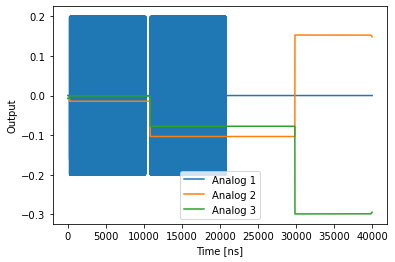

In [ ]:
pulser.open_qm(config,close_others=True)
a=pulser.simulate_pulse(seq,int(10e3))

In [36]:
samples=a[1]

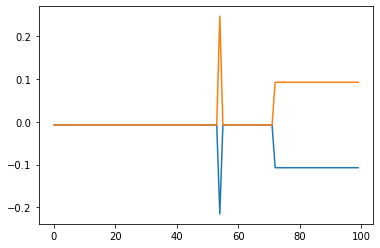

In [39]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(samples.con1.analog['3'][1200:1300])#[38000:42000])
plt.plot(samples.con1.analog['2'][1200:1300])#[38000:42000])

In [11]:
# pulser.seq_to_py(seq,'test3')

# bakery pulsing

In [ ]:
# from qualang_tools.bakery import baking
# baked_waveforms = []
# ch1_name = 'gate_36'
# ch2_name = 'gate_29'


# max_time_ns = 201
# total_length = max_time_ns + 4-(max_time_ns % 4)
# ch1_height = 31.1086*dividers['ch1']
# ch2_height = -25.17*dividers['ch2']

# for t in np.arange(0,max_time_ns,1):
#     with baking(config, padding_method = 'none') as b:
#         waveform_ch1 = [0]*(total_length-t-1)+[ch1_height]*t+[0]
#         waveform_ch2 = [0]*(total_length-t-1)+[ch2_height]*t+[0]

#         b.add_op('name_1',ch1_name,waveform_ch1)
#         b.add_op('name_2',ch2_name,waveform_ch2)

#         b.play('name_1',ch1_name)
#         b.play('name_2',ch2_name)

#     baked_waveforms.append(b)

In [4]:
from qm.qua import program, for_, reset_phase, stream_processing, switch_, case_, declare, declare_stream, wait, measure, play, save, fixed, demod, ramp, amp, if_, elif_, else_, align, ramp_to_zero
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm import SimulationConfig

with program() as seq2:
    baked_index = declare(int)
    amplitude_index = declare(int)
    amplitudes = declare(fixed,value = np.linspace(1,0.5,10).tolist())
    
    with for_(amplitude_index,0,amplitude_index<10,amplitude_index+1):
        with for_(baked_index,0,baked_index<200,baked_index+1):
            with switch_(baked_index,unsafe=True):
                for j in range(200):
                    with case_(j):
                        baked_waveforms[j].run(amp_array=[('gate_36',amplitudes[amplitude_index]),('gate_29',amplitudes[amplitude_index])])
                        
            play('CW'*amp(0.1*4),'gate_36',100)
            play('CW'*amp(-0.1*4),'gate_29',100)

            ramp_to_zero('gate_36',1)
            ramp_to_zero('gate_29',1)

2022-07-22 09:38:03,033 - qm - INFO - Performing health check
2022-07-22 09:38:03,045 - qm - INFO - Health check passed
quantum machine opened with channels ['gate_29', 'gate_36', 'bottom_right_DQD_readout']
default value for CW is: 0.25
2022-07-22 09:38:03,819 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2022-07-22 09:38:05,273 - qm - INFO - Flags: 
2022-07-22 09:38:05,275 - qm - INFO - Simulating program


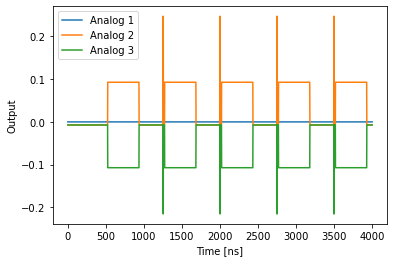

In [7]:
b=pulser.simulate_pulse(seq2,int(1e3),close_others=True)

In [8]:
samples1=b[1]

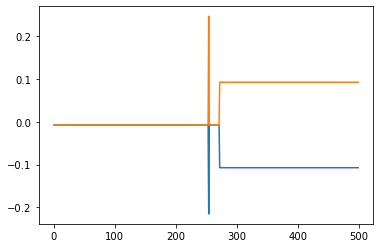

In [9]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(samples1.con1.analog['3'][1000:1500])#[38000:42000])
plt.plot(samples1.con1.analog['2'][1000:1500])#[38000:42000])


In [10]:
pulser.seq_to_py(seq2,'switch_test.py')